In [32]:
from hyperliquid.info import Info
from binance_common.configuration import ConfigurationRestAPI
from binance_common.constants import DERIVATIVES_TRADING_USDS_FUTURES_REST_API_PROD_URL
from binance_sdk_derivatives_trading_usds_futures.derivatives_trading_usds_futures import (
    DerivativesTradingUsdsFutures,
)
from binance_sdk_derivatives_trading_usds_futures.rest_api.models import (
    KlineCandlestickDataIntervalEnum,
)

import os
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timezone
from dateutil.relativedelta import relativedelta
from pathlib import Path
from dotenv import load_dotenv
from scipy.stats import pearsonr

from matplotlib.dates import AutoDateLocator, DateFormatter
from matplotlib.ticker import (
    MaxNLocator,
    SymmetricalLogLocator,
    LogFormatterSciNotation,
)
from matplotlib.patches import Patch

plt.style.use("seaborn-v0_8-white")
plt.rcParams.update(
    {
        "figure.dpi": 150,
        "axes.labelsize": 11,
        "axes.titlesize": 12,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
    }
)

# --- Global config ---
ASSET = "ETH"
N_REGIME = 21
LOOKBACK_MONTHS = 6

END_DT = datetime(2026, 2, 7, tzinfo=timezone.utc)
START_DT = END_DT - relativedelta(months=LOOKBACK_MONTHS)

# Data Sources

## 1. Funding Rates (Hyperliquid)

In [33]:
info = Info(skip_ws=True)

start_ms = int(START_DT.timestamp() * 1000)
end_ms = int(END_DT.timestamp() * 1000)

all_history = []
cursor = start_ms

while cursor < end_ms:
    batch = info.funding_history(name=ASSET, startTime=cursor, endTime=end_ms)
    if not batch:
        break

    all_history.extend(batch)
    last_ts = batch[-1]["time"]
    if last_ts <= cursor:
        break
    cursor = last_ts + 1

df_funding = pd.DataFrame(all_history)
df_funding["time"] = pd.to_datetime(df_funding["time"], unit="ms", utc=True)
df_funding["fundingRate"] = df_funding["fundingRate"].astype(float)
df_funding["premium"] = df_funding["premium"].astype(float)
df_funding = df_funding.sort_values("time").reset_index(drop=True)

df_funding.head(3)

,coin,fundingRate,premium,time
0,ETH,0.000008,-0.000433,2025-08-07 00:00:00.047000+00:00
1,ETH,0.000005,-0.000461,2025-08-07 01:00:00.057000+00:00
2,ETH,0.000009,-0.000427,2025-08-07 02:00:00.010000+00:00


## 2. Open Interest (Coinalyze)

In [34]:
load_dotenv()
COINALYZE_API_KEY = os.getenv("COINALYZE_API_KEY")
BASE_URL = "https://api.coinalyze.net/v1/"

start_s = int(START_DT.timestamp())
end_s = int(END_DT.timestamp())

params = {
    "symbols": "ETH.H",  # ETH perp Hyperliquid
    "interval": "1hour",
    "from": start_s,
    "to": end_s,
    "api_key": COINALYZE_API_KEY,
}

resp = requests.get(BASE_URL + "open-interest-history", params=params, timeout=10)
resp.raise_for_status()
data = resp.json()

df_oi = pd.DataFrame(data[0]["history"])
df_oi["t"] = pd.to_datetime(df_oi["t"], unit="s", utc=True)
df_oi.head(3)

,t,o,h,l,c
0,2025-11-27 16:00:00+00:00,427499.3340,430352.7776,427499.3340,430352.7776
1,2025-11-27 17:00:00+00:00,430358.8174,430640.0102,429132.6144,430001.2566
2,2025-11-27 18:00:00+00:00,429999.4048,430818.6972,429176.9914,429914.3328


## 3. Realized Volatility (Binance ETHUSDC 5m -> 1h RV)

In [35]:
config = ConfigurationRestAPI(
    base_path=DERIVATIVES_TRADING_USDS_FUTURES_REST_API_PROD_URL
)
client = DerivativesTradingUsdsFutures(config_rest_api=config)

start_ms = int(START_DT.timestamp() * 1000)
end_ms = int(END_DT.timestamp() * 1000)

rows = []
while start_ms < end_ms:
    resp = client.rest_api.kline_candlestick_data(
        symbol="ETHUSDC",
        interval=KlineCandlestickDataIntervalEnum.INTERVAL_5m,
        start_time=start_ms,
        end_time=end_ms,
        limit=1000,
    )
    data = resp.data()
    if not data:
        break

    rows.extend(data)
    last_close_time = data[-1][6]
    if last_close_time <= start_ms:
        break
    start_ms = last_close_time + 1

df_vol = pd.DataFrame(
    rows,
    columns=[
        "open_time",
        "open",
        "high",
        "low",
        "close",
        "volume",
        "close_time",
        "quote_volume",
        "trades",
        "taker_base",
        "taker_quote",
        "ignore",
    ],
)

df_vol["close_time"] = pd.to_datetime(df_vol["close_time"], unit="ms", utc=True)
df_vol["close"] = df_vol["close"].astype(float)
df_vol = df_vol.sort_values("close_time").reset_index(drop=True)
df_vol = df_vol[["close_time", "close"]]

df_vol["close_log_return"] = np.log(df_vol["close"] / df_vol["close"].shift(1))
df_vol = df_vol.dropna(subset=["close_log_return"])

df_rv = (
    df_vol.set_index("close_time")["close_log_return"]
    .resample("1h")
    .apply(lambda r: np.sqrt((r**2).sum()))
    .reset_index(name="rv_hourly")
)

df_rv.head(3)

,close_time,rv_hourly
0,2025-08-07 00:00:00+00:00,0.004917
1,2025-08-07 01:00:00+00:00,0.008461
2,2025-08-07 02:00:00+00:00,0.004132


# Feature Engineering

## 1. Funding regimes

In [ ]:
df_funding["is_pos"] = df_funding["fundingRate"] > 0
df_funding["is_nonpos"] = ~df_funding["is_pos"]

pos_run = df_funding["is_pos"].rolling(N_REGIME, min_periods=N_REGIME).sum()
nonpos_run = df_funding["is_nonpos"].rolling(N_REGIME, min_periods=N_REGIME).sum()

df_funding["regime"] = pd.Series(pd.NA, index=df_funding.index, dtype="Int8")
df_funding.loc[pos_run == N_REGIME, "regime"] = 1
df_funding.loc[nonpos_run == N_REGIME, "regime"] = 0

## 2. Merge Funding + OI + RV

In [37]:
df_panel = df_funding.copy()
df_panel["time_hour"] = df_panel["time"].dt.floor("h")

df_oi_ = df_oi.copy()
df_oi_["time_hour"] = df_oi_["t"].dt.floor("h")

df_rv_ = df_rv.copy()
df_rv_["time_hour"] = df_rv_["close_time"].dt.floor("h")

df_panel = (
    df_panel.merge(df_oi_[["time_hour", "c"]], on="time_hour", how="left")
    .merge(df_rv_[["time_hour", "rv_hourly"]], on="time_hour", how="left")
    .drop(columns=["time_hour"])
    .rename(columns={"c": "open_interest"})
)

df_panel = df_panel.sort_values("time").reset_index(drop=True)
df_panel.head(3)

,coin,fundingRate,premium,time,is_pos,is_nonpos,regime,open_interest,rv_hourly
0,ETH,0.000008,-0.000433,2025-08-07 00:00:00.047000+00:00,True,False,<NA>,NaN,0.004917
1,ETH,0.000005,-0.000461,2025-08-07 01:00:00.057000+00:00,True,False,<NA>,NaN,0.008461
2,ETH,0.000009,-0.000427,2025-08-07 02:00:00.010000+00:00,True,False,<NA>,NaN,0.004132


## 3. Features: funding_sign, ΔOI, RV-MA24

In [38]:
df_panel["funding_sign"] = (df_panel["fundingRate"] > 0).astype(int)
df_panel["oi_delta"] = df_panel["open_interest"].diff()
df_panel["rv_hourly_ma24"] = df_panel["rv_hourly"].rolling(24, min_periods=1).mean()

# Regime in Panel (optional nochmal konsistent)
df_panel["is_pos"] = df_panel["fundingRate"] > 0
df_panel["is_nonpos"] = ~df_panel["is_pos"]

pos_run = df_panel["is_pos"].rolling(N_REGIME, min_periods=N_REGIME).sum()
nonpos_run = df_panel["is_nonpos"].rolling(N_REGIME, min_periods=N_REGIME).sum()

df_panel["regime"] = pd.Series(pd.NA, index=df_panel.index, dtype="Int8")
df_panel.loc[pos_run == N_REGIME, "regime"] = 1
df_panel.loc[nonpos_run == N_REGIME, "regime"] = 0

# Analysis

## 1. Streak-Distribution (positive Funding)

Total streaks: 131
Median:        5.0
Mean:          30.083969465648856
Min/Max:       1 / 479
Q25/Q75/Q90:   2.0 / 21.0 / 53.0


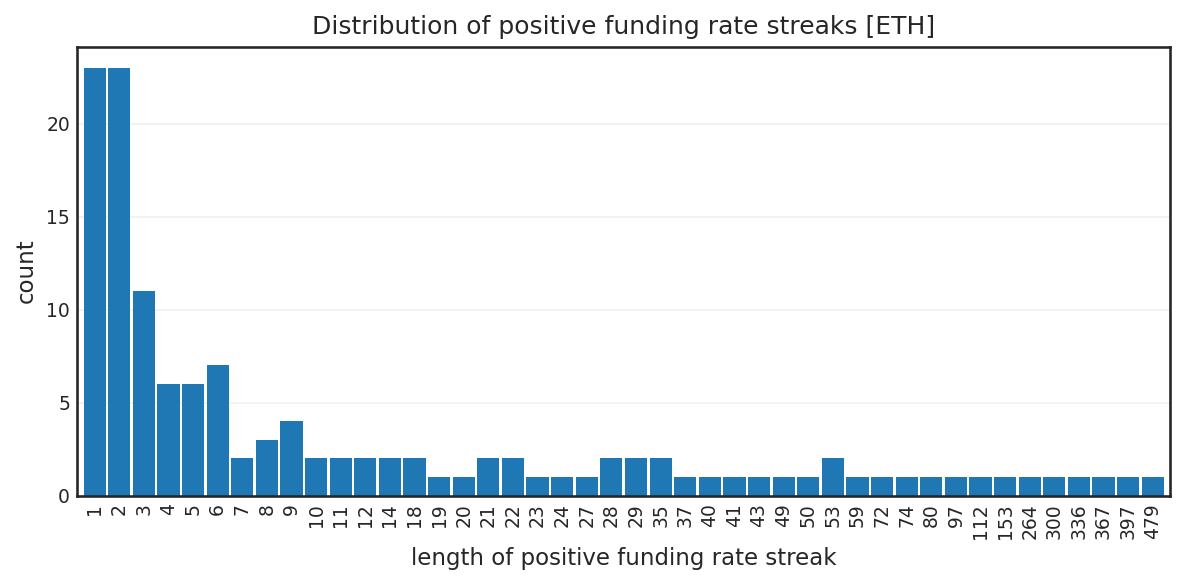

In [39]:
is_pos = df_funding["fundingRate"] > 0
group_id = (~is_pos).cumsum()
streak_lengths = is_pos.groupby(group_id).sum()
streak_lengths = streak_lengths[streak_lengths > 0]

print("Total streaks:", len(streak_lengths))
print("Median:       ", streak_lengths.median())
print("Mean:         ", streak_lengths.mean())
print("Min/Max:      ", streak_lengths.min(), "/", streak_lengths.max())
print(
    "Q25/Q75/Q90:  ",
    streak_lengths.quantile(0.25),
    "/",
    streak_lengths.quantile(0.75),
    "/",
    streak_lengths.quantile(0.90),
)

counts = streak_lengths.value_counts().sort_index()
fig, ax = plt.subplots(figsize=(8, 4))
counts.plot(kind="bar", ax=ax, width=0.9)

ax.set_xlabel("length of positive funding rate streak")
ax.set_ylabel("count")
ax.set_title("Distribution of positive funding rate streaks [ETH]")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Plot: Funding + Regime

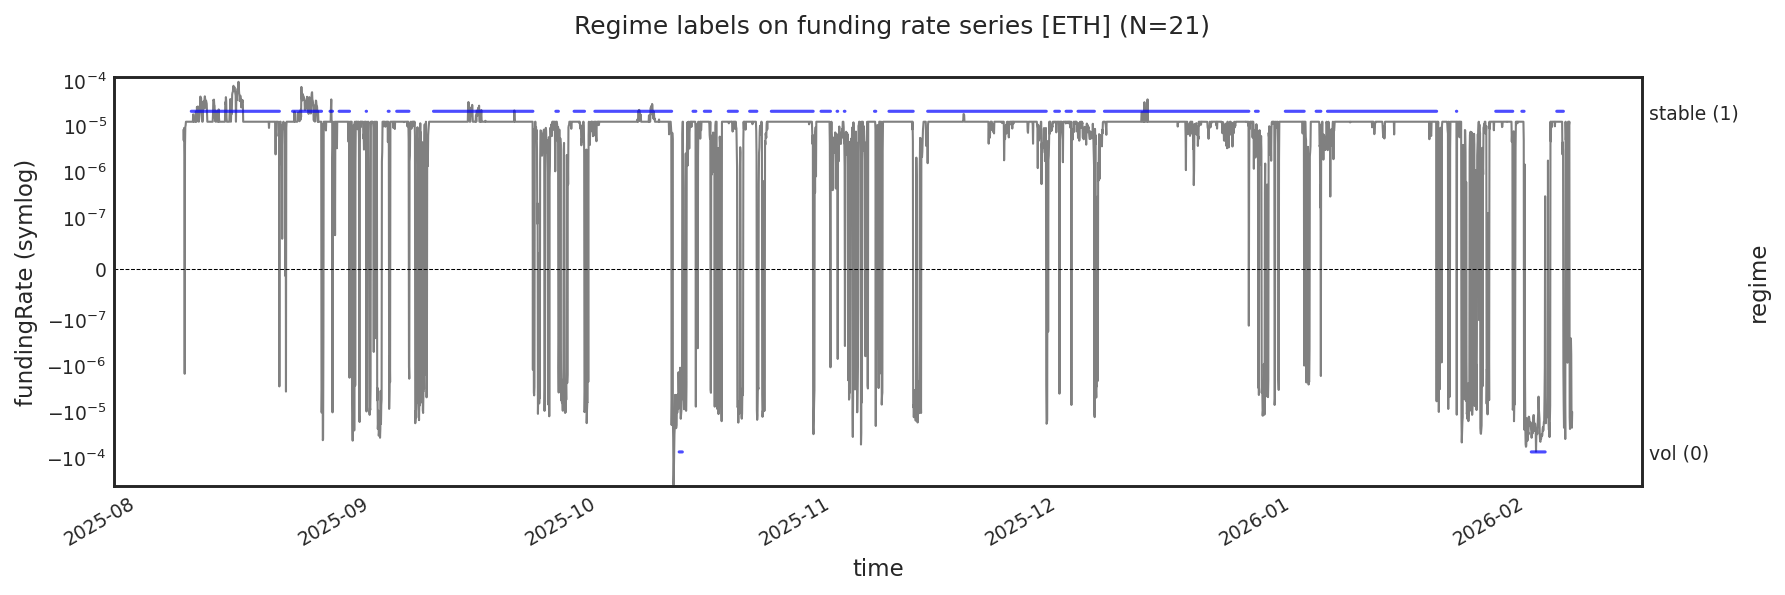

In [40]:
fig, ax1 = plt.subplots(figsize=(12, 4))
fig.suptitle(f"Regime labels on funding rate series [{ASSET}] (N={N_REGIME})")

ax1.plot(
    df_funding["time"],
    df_funding["fundingRate"],
    color="gray",
    linewidth=1,
    label="fundingRate",
)
ax1.axhline(0, color="black", linewidth=0.5, linestyle="--")
ax1.set_yscale("symlog", linthresh=1e-7)
ax1.set_xlabel("time")
ax1.set_ylabel("fundingRate (symlog)")

ax2 = ax1.twinx()
reg = pd.to_numeric(df_funding["regime"], errors="coerce")
ax2.step(
    df_funding["time"], reg, where="post", color="blue", alpha=0.7, label="regime (0/1)"
)
ax2.set_ylabel("regime")
ax2.set_ylim(-0.1, 1.1)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(["vol (0)", "stable (1)"])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## 4. Correlations

In [ ]:
# funding_sign vs ΔOI
sub_oi = df_panel[["funding_sign", "oi_delta"]].dropna()
r_oi, p_oi = pearsonr(sub_oi["funding_sign"], sub_oi["oi_delta"])
print("corr(funding_sign, oi_delta): r =", r_oi, "p =", p_oi)

# funding_sign vs RV (hourly)
sub_rv = df_panel[["funding_sign", "rv_hourly"]].dropna()
r_rv, p_rv = pearsonr(sub_rv["funding_sign"], sub_rv["rv_hourly"])
print("corr(funding_sign, rv_hourly): r =", r_rv, "p =", p_rv)

# funding_sign vs RV (24h MA)
sub_rv_ma = df_panel[["funding_sign", "rv_hourly_ma24"]].dropna()
r_rv_ma, p_rv_ma = pearsonr(sub_rv_ma["funding_sign"], sub_rv_ma["rv_hourly_ma24"])
print("corr(funding_sign, rv_hourly_ma24): r =", r_rv_ma, "p =", p_rv_ma)

# ΔOI vs RV
sub_oi_rv = df_panel[["oi_delta", "rv_hourly"]].dropna()
r_oi_rv, p_oi_rv = pearsonr(sub_oi_rv["oi_delta"], sub_oi_rv["rv_hourly"])
print("corr(oi_delta, rv_hourly): r =", r_oi_rv, "p =", p_oi_rv)

corr(funding_sign, oi_delta): r = 0.1209440621301837 p = 5.233979632187186e-07
corr(funding_sign, rv_hourly): r = -0.15864426453899938 p = 2.775625908713451e-26
corr(funding_sign, rv_hourly_ma24): r = -0.2180599290789007 p = 1.1054692482325466e-48
corr(oi_delta, rv_hourly): r = -0.02340609156325539 p = 0.33324413405987297


In [42]:
rv90 = df_panel["rv_hourly_ma24"].quantile(0.9)
high_rv = df_panel[df_panel["rv_hourly_ma24"] >= rv90]

sub_high = high_rv[["funding_sign", "rv_hourly_ma24"]].dropna()
r_high, p_high = pearsonr(sub_high["funding_sign"], sub_high["rv_hourly_ma24"])
print("corr(funding_sign, rv_hourly_ma24 | RV>=90p): r =", r_high, "p =", p_high)

corr(funding_sign, rv_hourly_ma24 | RV>=90p): r = -0.364317252914803 p = 2.5501308524898644e-15


## 4. Plots

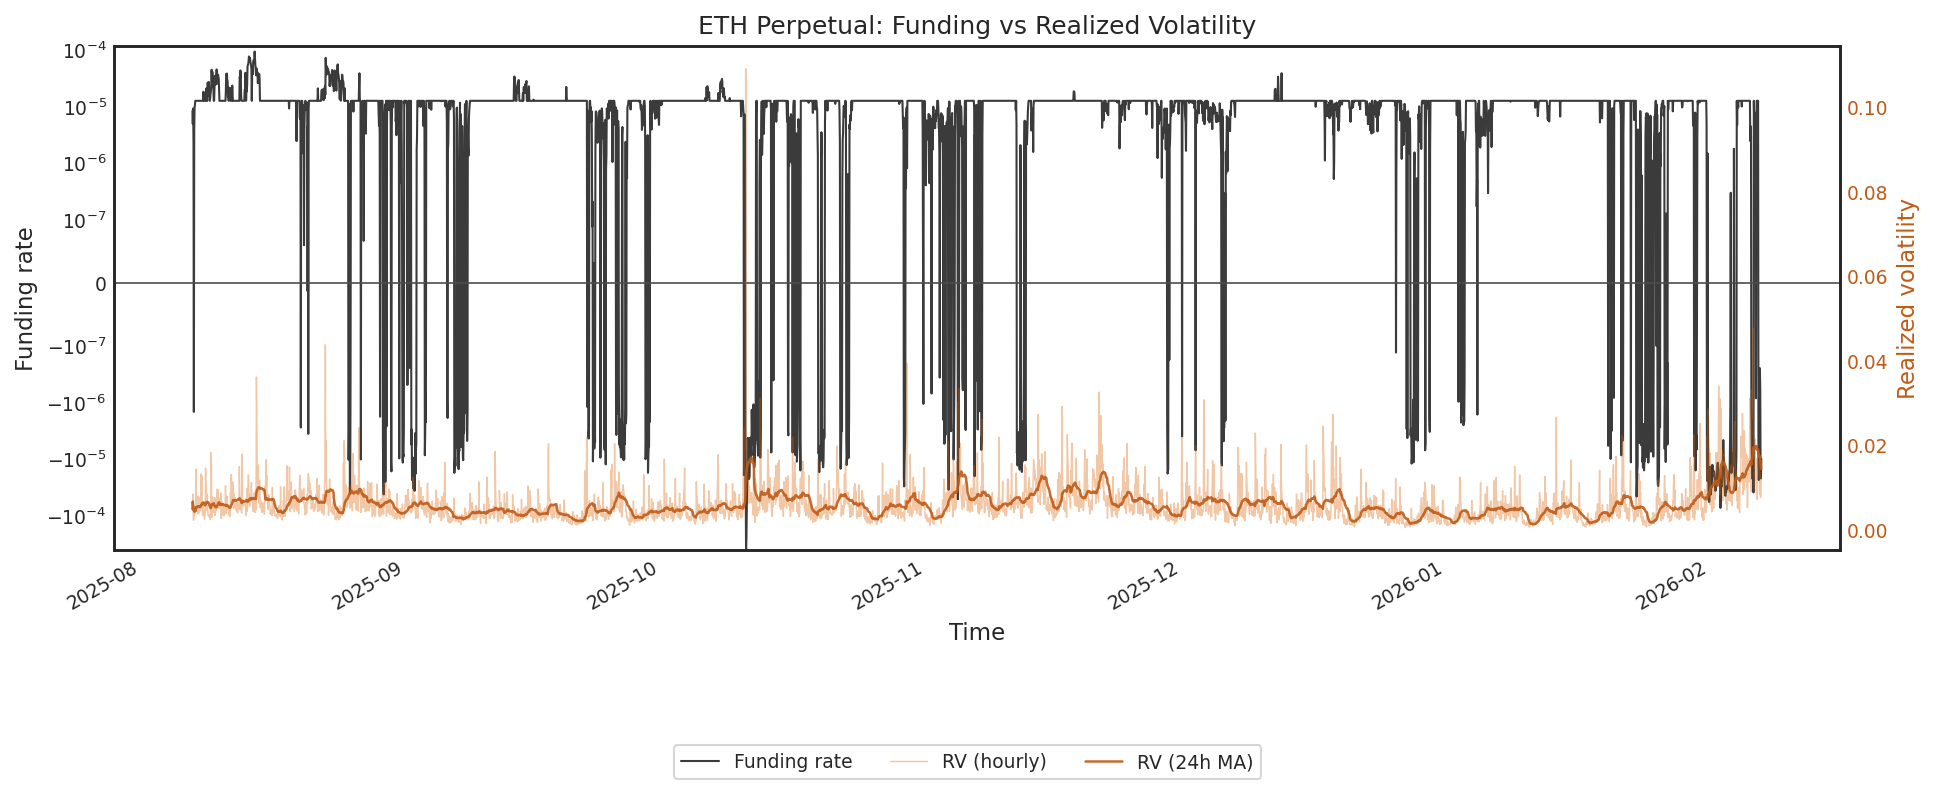

In [43]:
color_funding = "#3b3b3b"
color_rv = "#d95f02"
color_rv_ma = "#bf5b17"

fig, ax1 = plt.subplots(figsize=(13, 4.5))
ax1.set_title(f"{ASSET} Perpetual: Funding vs Realized Volatility")

ax1.plot(
    df_panel["time"],
    df_panel["fundingRate"],
    color=color_funding,
    linewidth=1.0,
    label="Funding rate",
)
ax1.axhline(0, color="0.3", linewidth=0.8)
ax1.set_yscale("symlog", linthresh=1e-7)
ax1.set_ylabel("Funding rate")
ax1.set_xlabel("Time")
ax1.yaxis.set_major_locator(SymmetricalLogLocator(base=10, linthresh=1e-7))
ax1.yaxis.set_major_formatter(LogFormatterSciNotation(base=10))

ax2 = ax1.twinx()
ax2.plot(
    df_panel["time"],
    df_panel["rv_hourly"],
    color=color_rv,
    linewidth=0.7,
    alpha=0.35,
    label="RV (hourly)",
)
ax2.plot(
    df_panel["time"],
    df_panel["rv_hourly_ma24"],
    color=color_rv_ma,
    linewidth=1.2,
    alpha=0.9,
    label="RV (24h MA)",
)
ax2.set_ylabel("Realized volatility", color=color_rv_ma)
ax2.tick_params(axis="y", labelcolor=color_rv_ma)
ax2.yaxis.set_major_locator(MaxNLocator(nbins=6))

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.18),
    ncol=3,
    frameon=True,
)

fig.subplots_adjust(bottom=0.25)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

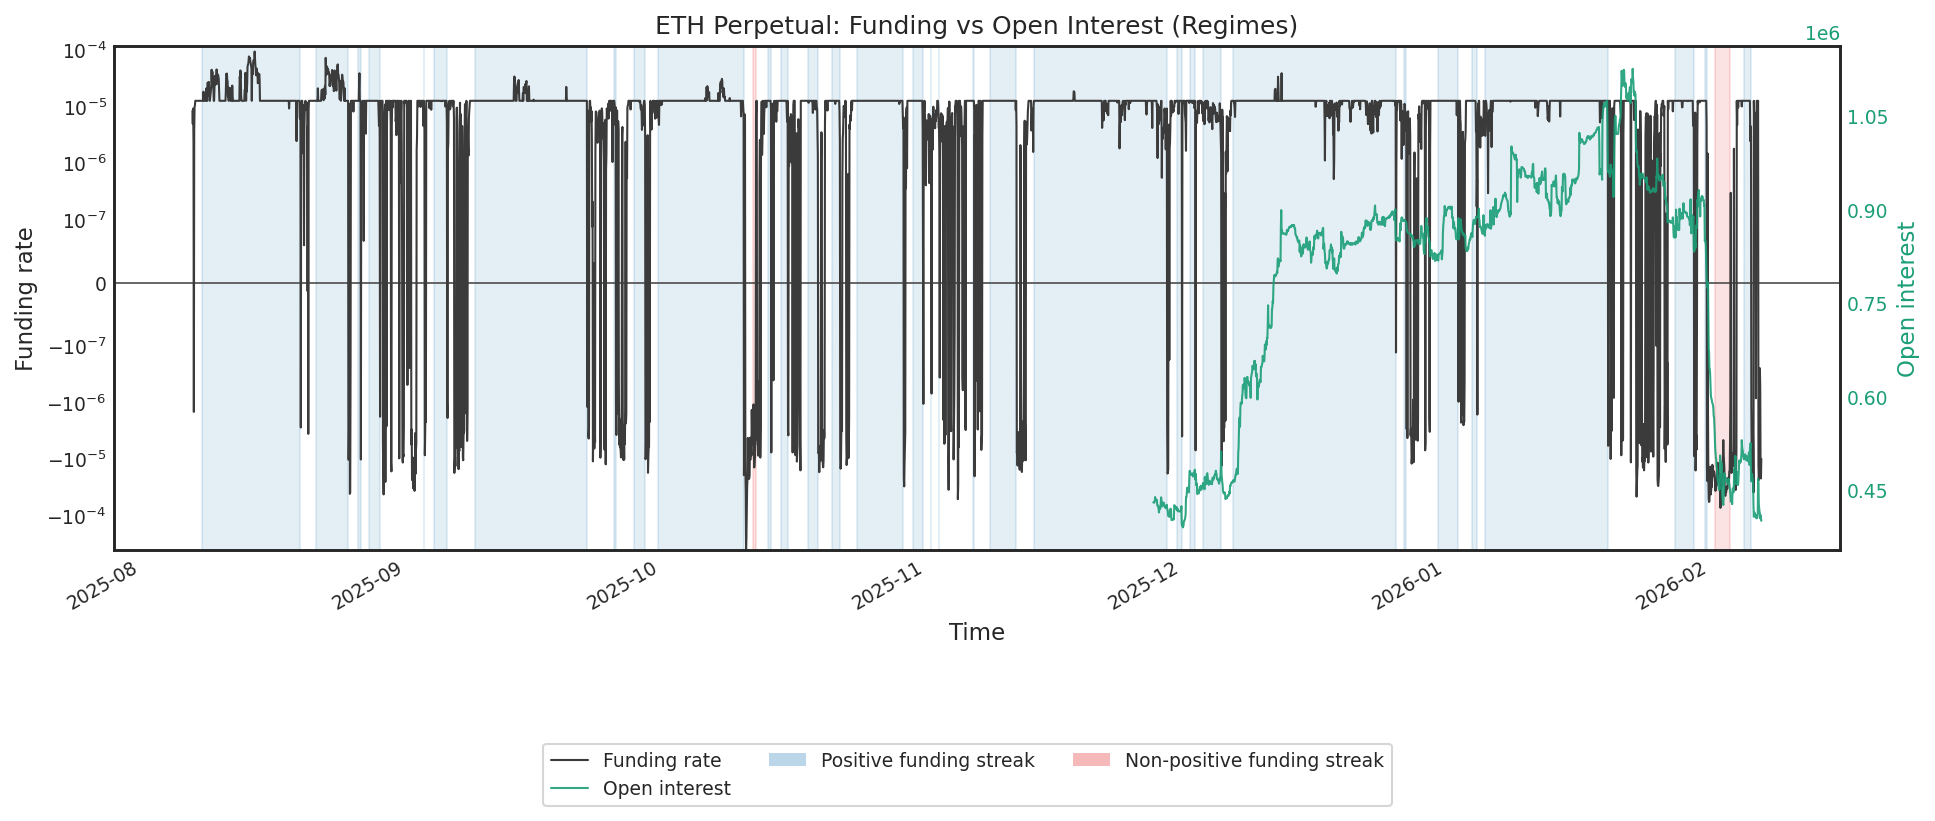

In [44]:
color_oi = "#1b9e77"
stable_color = "#1f78b4"
volatile_color = "#e31a1c"

reg = pd.to_numeric(df_panel["regime"], errors="coerce")

fig, ax1 = plt.subplots(figsize=(13, 4.5))
ax1.set_title(f"{ASSET} Perpetual: Funding vs Open Interest (Regimes)")

# Regime shading
mask = reg.isin([0, 1])
block_id = (reg.ne(reg.shift()) | ~mask).cumsum()
for _, grp in df_panel[mask].groupby(block_id):
    state = int(grp["regime"].iloc[0])
    start = grp["time"].iloc[0]
    end = grp["time"].iloc[-1]
    color = stable_color if state == 1 else volatile_color
    ax1.axvspan(start, end, color=color, alpha=0.12, zorder=0)

# Funding
ax1.plot(
    df_panel["time"],
    df_panel["fundingRate"],
    color=color_funding,
    linewidth=1.0,
    label="Funding rate",
    zorder=2,
)
ax1.axhline(0, color="0.3", linewidth=0.8, linestyle="-", zorder=1)
ax1.set_yscale("symlog", linthresh=1e-7)
ax1.set_ylabel("Funding rate")
ax1.set_xlabel("Time")
ax1.yaxis.set_major_locator(SymmetricalLogLocator(base=10, linthresh=1e-7))
ax1.yaxis.set_major_formatter(LogFormatterSciNotation(base=10))
ax1.grid(False)

# OI
ax2 = ax1.twinx()
ax2.plot(
    df_panel["time"],
    df_panel["open_interest"],
    color=color_oi,
    linewidth=1.0,
    alpha=0.9,
    label="Open interest",
)
ax2.set_ylabel("Open interest", color=color_oi)
ax2.tick_params(axis="y", labelcolor=color_oi)
ax2.yaxis.set_major_locator(MaxNLocator(nbins=6))

# Legend inkl. Regime-Patches
regime_handles = [
    Patch(facecolor=stable_color, alpha=0.3, label="Positive funding streak"),
    Patch(facecolor=volatile_color, alpha=0.3, label="Non-positive funding streak"),
]

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

fig.legend(
    lines1 + lines2 + regime_handles,
    labels1 + labels2 + [h.get_label() for h in regime_handles],
    loc="lower center",
    bbox_to_anchor=(0.5, -0.22),
    ncol=3,
    frameon=True,
)

fig.subplots_adjust(bottom=0.30)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()